<a href="https://colab.research.google.com/github/Sumisumisumith/Kickmotion-Evaluation-System/blob/main/StridedTransformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#ファイルにstrided transformerをクローン

%cd /content/drive/MyDrive/MyColab
!git clone https://github.com/Vegetebird/StridedTransformer-Pose3D.git

In [ ]:
#StridedTransformer-Pose3Dに必要なライブラリをインストール

%cd /content/drive/MyDrive/MyColab/StridedTransformer-Pose3D

!pip install --upgrade gdown
!pip install yacs
!pip install filterpy
!pip install einops
!pip install yt-dlp moviepy
!pip install matplotlib==3.7.1 # プログラムの関係上、matplotlibのバージョンを変更する必要がある

In [ ]:
#インストールした各ライブラリをインポート

%cd /content/drive/MyDrive/MyColab/StridedTransformer-Pose3D

import os
from yt_dlp import YoutubeDL

from moviepy.video.fx.resize import resize
from moviepy.editor import VideoFileClip, AudioFileClip, ImageSequenceClip, CompositeAudioClip
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip

In [ ]:
#学習済みモデルダウンロード

%cd /content/drive/MyDrive/MyColab/StridedTransformer-Pose3D
!mkdir -p ./checkpoint/pretrained

if not os.path.exists('checkpoint/pretrained/refine_4365.pth'):
  !gdown https://drive.google.com/uc?id=1aDLu0SB9JnPYZOOzQsJMV9zEIHg2Uro7 -O checkpoint/pretrained/refine_4365.pth
if not os.path.exists('checkpoint/pretrained/no_refine_4365.pth'):
  !gdown https://drive.google.com/uc?id=1l63AI9BsNovpfTAbfAkySo9X2MOWgYZH -O checkpoint/pretrained/no_refine_4365.pth

if not os.path.exists('demo/lib/checkpoint/yolov3.weights'):
  !gdown https://drive.google.com/uc?id=1gWZl1VrlLZKBf0Pfkj4hKiFxe8sHP-1C -O demo/lib/checkpoint/yolov3.weights
if not os.path.exists('demo/lib/checkpoint/pose_hrnet_w48_384x288.pth'):
  !gdown https://drive.google.com/uc?id=1CpyZiUIUlEjiql4rILwdBT4666S72Oq4 -O demo/lib/checkpoint/pose_hrnet_w48_384x288.pth

In [ ]:
#StridedTransformer/demo/videoに、youtubeから切り取った入力動画を配置

%cd /content/drive/MyDrive/MyColab/StridedTransformer-Pose3D

video_url = 'https://youtu.be/0wVKezD0Czw' #@param {type:"string"}

#@markdown 動画の切り抜き範囲(秒)を指定してください。\
#@markdown 30秒以上の場合OOM発生の可能性が高いため注意
start_sec =  0#@param {type:"integer"}
end_sec =  8#@param {type:"integer"}

(start_pt, end_pt) = (start_sec, end_sec)

download_resolution = 360
full_video_path = '/content/drive/MyDrive/MyColab/StridedTransformer-Pose3D/demo/video/full_video.mp4'
file_name = 'input_clip.mp4'
input_clip_path = '/content/drive/MyDrive/MyColab/StridedTransformer-Pose3D/demo/video/' + file_name

# 動画ダウンロード
ydl_opts = {'format': f'best[height<={download_resolution}]', 'overwrites': True, 'outtmpl': full_video_path}
with YoutubeDL(ydl_opts) as ydl:
    ydl.download([video_url])

# 指定区間切り抜き
with VideoFileClip(full_video_path) as video:
    subclip = video.subclip(start_pt, end_pt)
    subclip.write_videofile(input_clip_path)

In [ ]:
#入力ファイルを指定してvis.pyを実行する(実行結果はStridedTransformer/demo/output/input_clip/input_clip.mp4)

%cd /content/drive/MyDrive/MyColab/StridedTransformer-Pose3D

!python demo/vis.py --video {file_name}

output = VideoFileClip('/content/drive/MyDrive/MyColab/StridedTransformer-Pose3D/demo/output/input_clip/input_clip.mp4')
output = resize(output, height=420)
output.ipython_display()

In [ ]:
## vis.py実行
%cd /content/drive/MyDrive/MyColab/StridedTransformer-Pose3D

!python demo/vis.py --video E5_02.mov

# 出力結果はoutputのフォルダ内
# 撮影したデータをiphoneから直接ドライブにアップロードするとエラーが起きる(原因不明、拡張子の影響?)なので、slackやlineなどにあげてからcolabにダウンロードする
# EはExpert, NEはNon-Expert

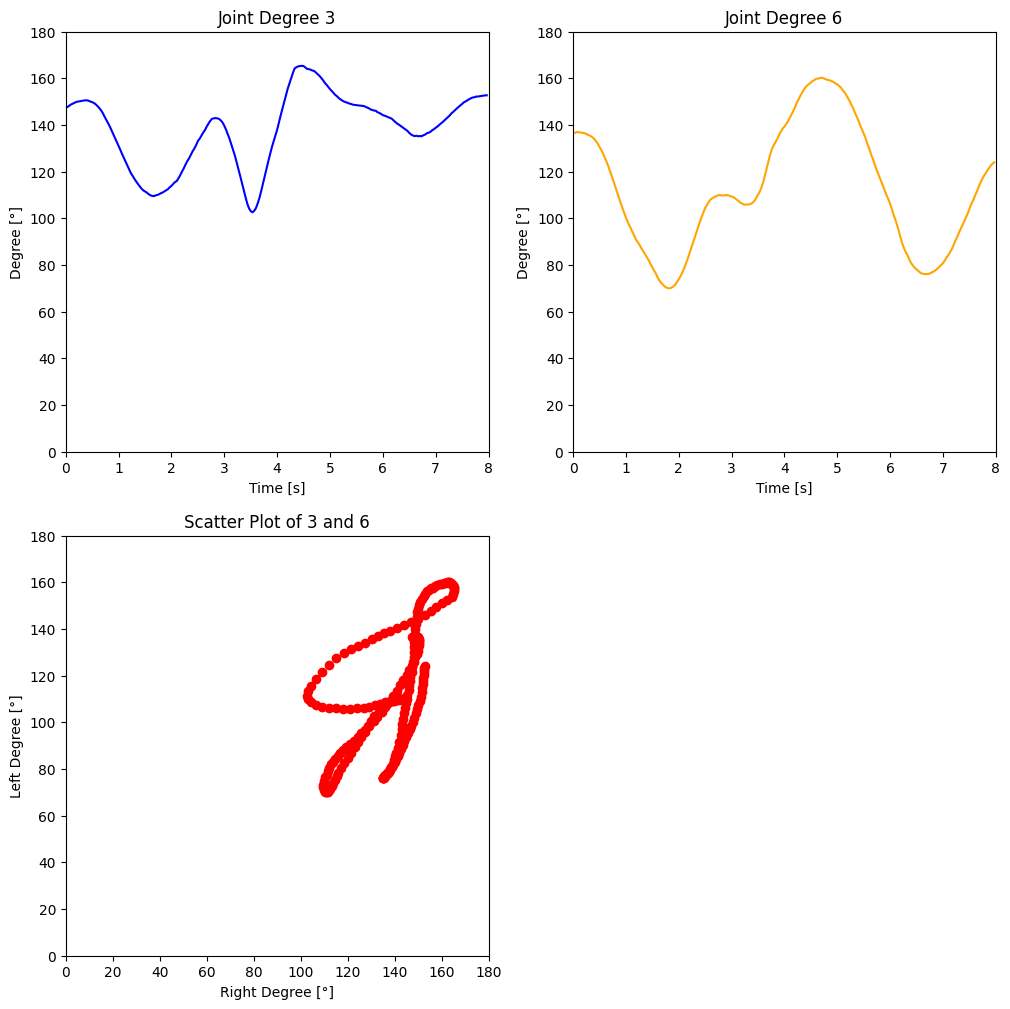

In [ ]:
# 各被験者の関節角度＆速度の計算
import csv
import math
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation

# 17行3列ずつデータを読み取る関数
def read_3d_data(file, batch_size=17):
    data = []
    with open(file, mode='r', newline='') as csvfile:
        reader = csv.reader(csvfile)
        batch = []
        for row in reader:
            batch.append([float(val) for val in row])
            if len(batch) == batch_size:
                data.append(batch)
                batch = []
    return data

# 関節角度を計算する関数
def joint_deg(data, joint_num):
    deg = []
    joint_num = joint_num - 1
    frames = 240 #1秒の動画を240fpsでスロー化しているので＆データ数を統一するため
    for frame in range(frames):
        a = data[frame][joint_num - 1] - data[frame][joint_num]
        b = data[frame][joint_num + 1] - data[frame][joint_num]
        x = np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
        rad = math.acos(x)
        deg.append(math.degrees(rad))
    return deg

# 関節速度を計算する関数
def joint_v(data,joint_num):
    v = []
    joint_num = joint_num - 1
    for frame in range(len(data)-1):
        d = data[frame+1][joint_num] - data[frame][joint_num]
        v.append(np.linalg.norm(d))
    return v


# CSVファイル名
csv_filename = '/content/drive/MyDrive/MyColab/StridedTransformer-Pose3D/demo/csvdata/E5_02.csv'

# 三次元関節座標データの読み込み
data = np.array(read_3d_data(csv_filename))

# 時間設定
frames = 240 #240fpsなので
t = np.arange(frames)/30

fig = plt.figure(figsize=(12,12)) #グラフ用意
# 右足関節角度グラフ表示
joint_deg_right_num = 3
deg_right = joint_deg(data, joint_deg_right_num)

ax_deg_3 = fig.add_subplot(2, 2, 1)
ax_deg_3.set_title("Joint Degree " + str(joint_deg_right_num))
ax_deg_3.set_xlabel("Time [s]")
ax_deg_3.set_ylabel("Degree [°]")
ax_deg_3.set_xlim([0, 8])
ax_deg_3.set_ylim([0, 180])
ax_deg_3.plot(t, deg_right, color="blue")

# 左足関節角度グラフ表示
joint_deg_left_num = 6
deg_left = joint_deg(data, joint_deg_left_num)

ax_deg_3 = fig.add_subplot(2, 2, 2)
ax_deg_3.set_title("Joint Degree " + str(joint_deg_left_num))
ax_deg_3.set_xlabel("Time [s]")
ax_deg_3.set_ylabel("Degree [°]")
ax_deg_3.set_xlim([0, 8])
ax_deg_3.set_ylim([0, 180])
ax_deg_3.plot(t, deg_left, color="orange")

"""
# 関節速度グラフ表示
joint_deg_num2 = 6
v = joint_v(data, joint_v_num)
t = np.arange(len(data)-1)

ax_v_3 = fig.add_subplot(2, 2, 2)
ax_v_3.set_title("Joint Velocity " + str(joint_v_num))
ax_v_3.set_xlabel("Time [frame]")
ax_v_3.set_ylabel("Velocity  [distans/frame]")
ax_v_3.set_xlim([0, 240])
ax_v_3.set_ylim([0, 0.1])
ax_v_3.plot(t, v, color="orange")
"""

# 関節角度＆角度の散布図表示
ax = fig.add_subplot(2, 2, 3)
ax.set_title("Scatter Plot of " + str(joint_deg_right_num) + " and " + str(joint_deg_left_num))
ax.set_xlabel("Right Degree [°]")
ax.set_ylabel("Left Degree [°]")
ax.set_xlim([0, 180])
ax.set_ylim([0, 180])
ax.scatter(deg_right, deg_left, color="red")

plt.show()

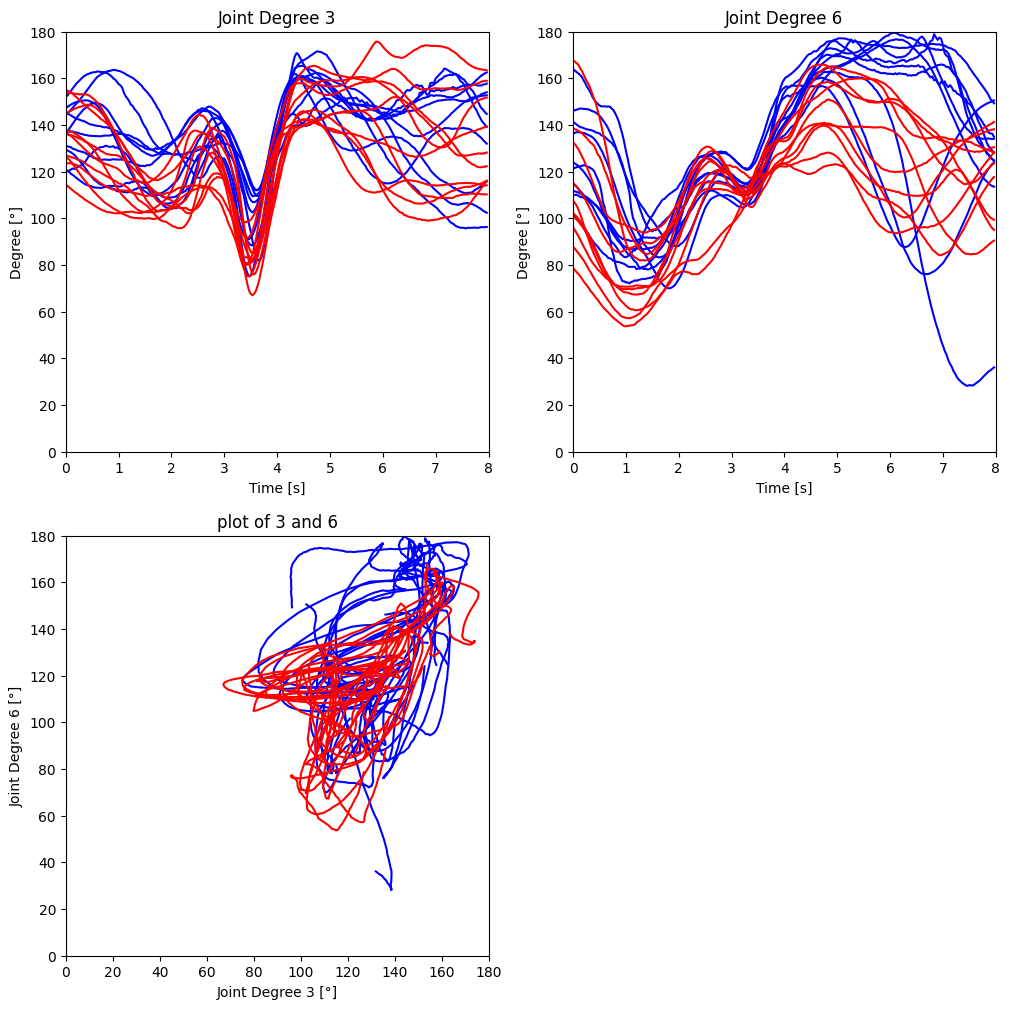

In [ ]:
# 全被験者の関節角度＆散布図表示
import csv
import math
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation

# 17行3列ずつデータを読み取る関数
def read_3d_data(file, batch_size=17):
    data = []
    with open(file, mode='r', newline='') as csvfile:
        reader = csv.reader(csvfile)
        batch = []
        for row in reader:
            batch.append([float(val) for val in row])
            if len(batch) == batch_size:
                data.append(batch)
                batch = []
    return data

# 関節角度を計算する関数
def joint_deg(data, joint_num):
    deg = []
    joint_num = joint_num - 1
    frames = 240 #1秒の動画を240fpsでスロー化しているので＆データ数を統一するため
    for frame in range(frames):
        a = data[frame][joint_num - 1] - data[frame][joint_num]
        b = data[frame][joint_num + 1] - data[frame][joint_num]
        x = np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
        rad = math.acos(x)
        deg.append(math.degrees(rad))
    return deg

# CSVファイル名
csvfile_E1_01 = '/content/drive/MyDrive/MyColab/StridedTransformer-Pose3D/demo/csvdata/E1_01.csv'
csvfile_E1_02 = '/content/drive/MyDrive/MyColab/StridedTransformer-Pose3D/demo/csvdata/E1_02.csv'
csvfile_E2_01 = '/content/drive/MyDrive/MyColab/StridedTransformer-Pose3D/demo/csvdata/E2_01.csv'
csvfile_E2_02 = '/content/drive/MyDrive/MyColab/StridedTransformer-Pose3D/demo/csvdata/E2_02.csv'
csvfile_E3_01 = '/content/drive/MyDrive/MyColab/StridedTransformer-Pose3D/demo/csvdata/E3_01.csv'
csvfile_E3_02 = '/content/drive/MyDrive/MyColab/StridedTransformer-Pose3D/demo/csvdata/E3_02.csv'
csvfile_E4_01 = '/content/drive/MyDrive/MyColab/StridedTransformer-Pose3D/demo/csvdata/E4_01.csv'
csvfile_E4_02 = '/content/drive/MyDrive/MyColab/StridedTransformer-Pose3D/demo/csvdata/E4_02.csv'
csvfile_E5_01 = '/content/drive/MyDrive/MyColab/StridedTransformer-Pose3D/demo/csvdata/E5_01.csv'
csvfile_E5_02 = '/content/drive/MyDrive/MyColab/StridedTransformer-Pose3D/demo/csvdata/E5_02.csv'

csvfile_NE1_01 = '/content/drive/MyDrive/MyColab/StridedTransformer-Pose3D/demo/csvdata/NE1_01.csv'
csvfile_NE1_02 = '/content/drive/MyDrive/MyColab/StridedTransformer-Pose3D/demo/csvdata/NE1_02.csv'
csvfile_NE2_01 = '/content/drive/MyDrive/MyColab/StridedTransformer-Pose3D/demo/csvdata/NE2_01.csv'
csvfile_NE2_02 = '/content/drive/MyDrive/MyColab/StridedTransformer-Pose3D/demo/csvdata/NE2_02.csv'
csvfile_NE3_01 = '/content/drive/MyDrive/MyColab/StridedTransformer-Pose3D/demo/csvdata/NE3_01.csv'
csvfile_NE3_02 = '/content/drive/MyDrive/MyColab/StridedTransformer-Pose3D/demo/csvdata/NE3_02.csv'
csvfile_NE4_01 = '/content/drive/MyDrive/MyColab/StridedTransformer-Pose3D/demo/csvdata/NE4_01.csv'
csvfile_NE4_02 = '/content/drive/MyDrive/MyColab/StridedTransformer-Pose3D/demo/csvdata/NE4_02.csv'
csvfile_NE5_01 = '/content/drive/MyDrive/MyColab/StridedTransformer-Pose3D/demo/csvdata/NE5_01.csv'
csvfile_NE5_02 = '/content/drive/MyDrive/MyColab/StridedTransformer-Pose3D/demo/csvdata/NE5_02.csv'

# 三次元関節座標データの読み込み
data_E1_01 = np.array(read_3d_data(csvfile_E1_01))
data_E1_02 = np.array(read_3d_data(csvfile_E1_02))
data_E2_01 = np.array(read_3d_data(csvfile_E2_01))
data_E2_02 = np.array(read_3d_data(csvfile_E2_02))
data_E3_01 = np.array(read_3d_data(csvfile_E3_01))
data_E3_02 = np.array(read_3d_data(csvfile_E3_02))
data_E4_01 = np.array(read_3d_data(csvfile_E4_01))
data_E4_02 = np.array(read_3d_data(csvfile_E4_02))
data_E5_01 = np.array(read_3d_data(csvfile_E5_01))
data_E5_02 = np.array(read_3d_data(csvfile_E5_02))

data_NE1_01 = np.array(read_3d_data(csvfile_NE1_01))
data_NE1_02 = np.array(read_3d_data(csvfile_NE1_02))
data_NE2_01 = np.array(read_3d_data(csvfile_NE2_01))
data_NE2_02 = np.array(read_3d_data(csvfile_NE2_02))
data_NE3_01 = np.array(read_3d_data(csvfile_NE3_01))
data_NE3_02 = np.array(read_3d_data(csvfile_NE3_02))
data_NE4_01 = np.array(read_3d_data(csvfile_NE4_01))
data_NE4_02 = np.array(read_3d_data(csvfile_NE4_02))
data_NE5_01 = np.array(read_3d_data(csvfile_NE5_01))
data_NE5_02 = np.array(read_3d_data(csvfile_NE5_02))

# 時間設定
frames = 240 #240fpsなので
t = list(np.arange(frames)/30)

# 右足関節角度グラフ表示
joint_degR_num = 3

degR_E1_01 = joint_deg(data_E1_01, joint_degR_num)
degR_E1_02 = joint_deg(data_E1_02, joint_degR_num)
degR_E2_01 = joint_deg(data_E2_01, joint_degR_num)
degR_E2_02 = joint_deg(data_E2_02, joint_degR_num)
degR_E3_01 = joint_deg(data_E3_01, joint_degR_num)
degR_E3_02 = joint_deg(data_E3_02, joint_degR_num)
degR_E4_01 = joint_deg(data_E4_01, joint_degR_num)
degR_E4_02 = joint_deg(data_E4_02, joint_degR_num)
degR_E5_01 = joint_deg(data_E5_01, joint_degR_num)
degR_E5_02 = joint_deg(data_E5_02, joint_degR_num)

degR_NE1_01 = joint_deg(data_NE1_01, joint_degR_num)
degR_NE1_02 = joint_deg(data_NE1_02, joint_degR_num)
degR_NE2_01 = joint_deg(data_NE2_01, joint_degR_num)
degR_NE2_02 = joint_deg(data_NE2_02, joint_degR_num)
degR_NE3_01 = joint_deg(data_NE3_01, joint_degR_num)
degR_NE3_02 = joint_deg(data_NE3_02, joint_degR_num)
degR_NE4_01 = joint_deg(data_NE4_01, joint_degR_num)
degR_NE4_02 = joint_deg(data_NE4_02, joint_degR_num)
degR_NE5_01 = joint_deg(data_NE5_01, joint_degR_num)
degR_NE5_02 = joint_deg(data_NE5_02, joint_degR_num)

fig = plt.figure(figsize=(12,12)) #グラフ用意
ax_degR = fig.add_subplot(2, 2, 1)
ax_degR.set_title("Joint Degree " + str(joint_degR_num))
ax_degR.set_xlabel("Time [s]")
ax_degR.set_ylabel("Degree [°]")
ax_degR.set_xlim([0, 8])
ax_degR.set_ylim([0, 180])

ax_degR.plot(t, degR_E1_01, color="blue")
ax_degR.plot(t, degR_E1_02, color="blue")
ax_degR.plot(t, degR_E2_01, color="blue")
ax_degR.plot(t, degR_E2_02, color="blue")
ax_degR.plot(t, degR_E3_01, color="blue")
ax_degR.plot(t, degR_E3_02, color="blue")
ax_degR.plot(t, degR_E4_01, color="blue")
ax_degR.plot(t, degR_E4_02, color="blue")
ax_degR.plot(t, degR_E5_01, color="blue")
ax_degR.plot(t, degR_E5_02, color="blue")

ax_degR.plot(t, degR_NE1_01, color="red")
ax_degR.plot(t, degR_NE1_02, color="red")
ax_degR.plot(t, degR_NE2_01, color="red")
ax_degR.plot(t, degR_NE2_02, color="red")
ax_degR.plot(t, degR_NE3_01, color="red")
ax_degR.plot(t, degR_NE3_02, color="red")
ax_degR.plot(t, degR_NE4_01, color="red")
ax_degR.plot(t, degR_NE4_02, color="red")
ax_degR.plot(t, degR_NE5_01, color="red")
ax_degR.plot(t, degR_NE5_02, color="red")

# 左足足関節角度グラフ表示
joint_degL_num = 6

degL_E1_01 = joint_deg(data_E1_01, joint_degL_num)
degL_E1_02 = joint_deg(data_E1_02, joint_degL_num)
degL_E2_01 = joint_deg(data_E2_01, joint_degL_num)
degL_E2_02 = joint_deg(data_E2_02, joint_degL_num)
degL_E3_01 = joint_deg(data_E3_01, joint_degL_num)
degL_E3_02 = joint_deg(data_E3_02, joint_degL_num)
degL_E4_01 = joint_deg(data_E4_01, joint_degL_num)
degL_E4_02 = joint_deg(data_E4_02, joint_degL_num)
degL_E5_01 = joint_deg(data_E5_01, joint_degL_num)
degL_E5_02 = joint_deg(data_E5_02, joint_degL_num)

degL_NE1_01 = joint_deg(data_NE1_01, joint_degL_num)
degL_NE1_02 = joint_deg(data_NE1_02, joint_degL_num)
degL_NE2_01 = joint_deg(data_NE2_01, joint_degL_num)
degL_NE2_02 = joint_deg(data_NE2_02, joint_degL_num)
degL_NE3_01 = joint_deg(data_NE3_01, joint_degL_num)
degL_NE3_02 = joint_deg(data_NE3_02, joint_degL_num)
degL_NE4_01 = joint_deg(data_NE4_01, joint_degL_num)
degL_NE4_02 = joint_deg(data_NE4_02, joint_degL_num)
degL_NE5_01 = joint_deg(data_NE5_01, joint_degL_num)
degL_NE5_02 = joint_deg(data_NE5_02, joint_degL_num)

ax_degL = fig.add_subplot(2, 2, 2)
ax_degL.set_title("Joint Degree " + str(joint_degL_num))
ax_degL.set_xlabel("Time [s]")
ax_degL.set_ylabel("Degree [°]")
ax_degL.set_xlim([0, 8])
ax_degL.set_ylim([0, 180])

ax_degL.plot(t, degL_E1_01, color="blue")
ax_degL.plot(t, degL_E1_02, color="blue")
ax_degL.plot(t, degL_E2_01, color="blue")
ax_degL.plot(t, degL_E2_02, color="blue")
ax_degL.plot(t, degL_E3_01, color="blue")
ax_degL.plot(t, degL_E3_02, color="blue")
ax_degL.plot(t, degL_E4_01, color="blue")
ax_degL.plot(t, degL_E4_02, color="blue")
ax_degL.plot(t, degL_E5_01, color="blue")
ax_degL.plot(t, degL_E5_02, color="blue")

ax_degL.plot(t, degL_NE1_01, color="red")
ax_degL.plot(t, degL_NE1_02, color="red")
ax_degL.plot(t, degL_NE2_01, color="red")
ax_degL.plot(t, degL_NE2_02, color="red")
ax_degL.plot(t, degL_NE3_01, color="red")
ax_degL.plot(t, degL_NE3_02, color="red")
ax_degL.plot(t, degL_NE4_01, color="red")
ax_degL.plot(t, degL_NE4_02, color="red")
ax_degL.plot(t, degL_NE5_01, color="red")
ax_degL.plot(t, degL_NE5_02, color="red")

# 関節角度＆角度の散布図表示
ax = fig.add_subplot(2, 2, 3)
ax.set_title("plot of " + str(joint_degR_num) + " and " + str(joint_degL_num))
ax.set_xlabel("Joint Degree 3 [°]")
ax.set_ylabel("Joint Degree 6 [°]")
ax.set_xlim([0, 180])
ax.set_ylim([0, 180])

ax.plot(degR_E1_01, degL_E1_01, color="blue")
ax.plot(degR_E1_02, degL_E1_02, color="blue")
ax.plot(degR_E2_01, degL_E2_01, color="blue")
ax.plot(degR_E2_02, degL_E2_02, color="blue")
ax.plot(degR_E3_01, degL_E3_01, color="blue")
ax.plot(degR_E3_02, degL_E3_02, color="blue")
ax.plot(degR_E4_01, degL_E4_01, color="blue")
ax.plot(degR_E4_02, degL_E4_02, color="blue")
ax.plot(degR_E5_01, degL_E5_01, color="blue")
ax.plot(degR_E5_02, degL_E5_02, color="blue")

ax.plot(degR_NE1_01, degL_NE1_01, color="red")
ax.plot(degR_NE1_02, degL_NE1_02, color="red")
ax.plot(degR_NE2_01, degL_NE2_01, color="red")
ax.plot(degR_NE2_02, degL_NE2_02, color="red")
ax.plot(degR_NE3_01, degL_NE3_01, color="red")
ax.plot(degR_NE3_02, degL_NE3_02, color="red")
ax.plot(degR_NE4_01, degL_NE4_01, color="red")
ax.plot(degR_NE4_02, degL_NE4_02, color="red")
ax.plot(degR_NE5_01, degL_NE5_01, color="red")
ax.plot(degR_NE5_02, degL_NE5_02, color="red")

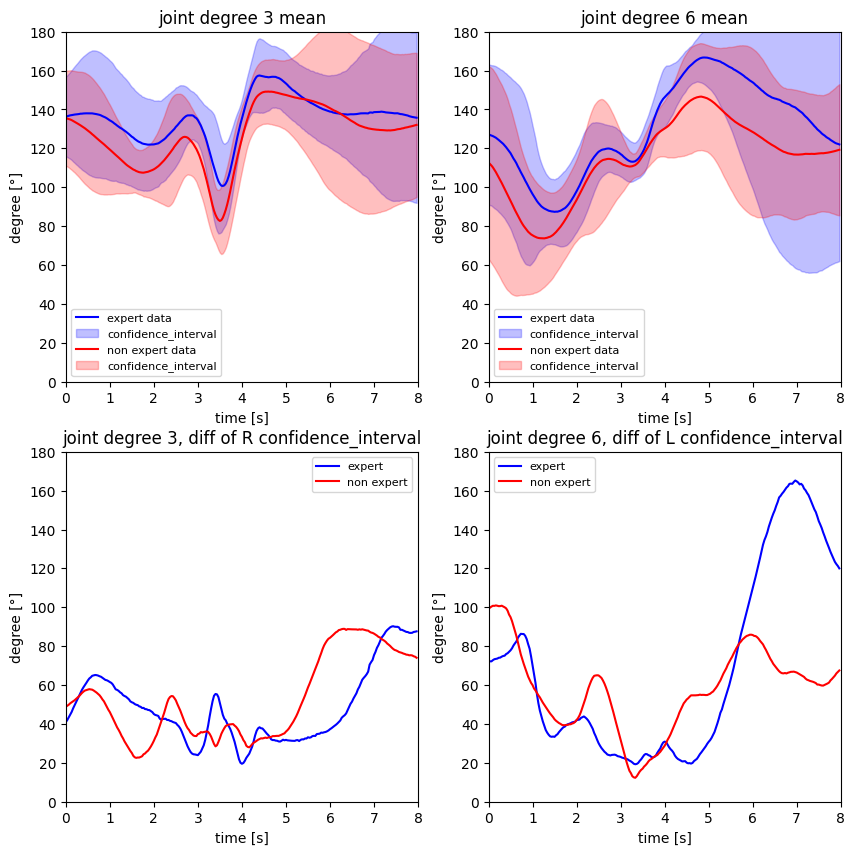

In [ ]:
# ガウス分布を用いた平均からのばらつきの可視化

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# 関節データの平均
degR_E_mean = (np.array(degR_E1_01) + np.array(degR_E1_02) + np.array(degR_E2_01) + np.array(degR_E2_02) + np.array(degR_E3_01) + np.array(degR_E3_02) + np.array(degR_E4_01) + np.array(degR_E4_02) + np.array(degR_E5_01) + np.array(degR_E5_02)) / 10
degL_E_mean = (np.array(degL_E1_01) + np.array(degL_E1_02) + np.array(degL_E2_01) + np.array(degL_E2_02) + np.array(degL_E3_01) + np.array(degL_E3_02) + np.array(degL_E4_01) + np.array(degL_E4_02) + np.array(degL_E5_01) + np.array(degL_E5_02)) / 10
degR_NE_mean = (np.array(degR_NE1_01) + np.array(degR_NE1_02) + np.array(degR_NE2_01) + np.array(degR_NE2_02) + np.array(degR_NE3_01) + np.array(degR_NE3_02) + np.array(degR_NE4_01) + np.array(degR_NE4_02) + np.array(degR_NE5_01) + np.array(degR_NE5_02)) / 10
degL_NE_mean = (np.array(degL_NE1_01) + np.array(degL_NE1_02) + np.array(degL_NE2_01) + np.array(degL_NE2_02) + np.array(degL_NE3_01) + np.array(degL_NE3_02) + np.array(degL_NE4_01) + np.array(degL_NE4_02) + np.array(degL_NE5_01) + np.array(degL_NE5_02)) / 10

# 定数設定＆変数宣言
frames = 240
dataR_E = []
dataL_E = []
dataR_NE = []
dataL_NE = []
confidence_interval_R_E = []
confidence_interval_L_E = []
confidence_interval_R_NE = []
confidence_interval_L_NE = []

# ガウス分布作成
for i in range(frames):
    # 各データを合わせた10行240列の配列を作成
    dataR_E.append([degR_E1_01[i], degR_E1_02[i], degR_E2_01[i], degR_E2_02[i], degR_E3_01[i], degR_E3_02[i], degR_E4_01[i], degR_E4_02[i], degR_E5_01[i], degR_E5_02[i]])
    dataL_E.append([degL_E1_01[i], degL_E1_02[i], degL_E2_01[i], degL_E2_02[i], degL_E3_01[i], degL_E3_02[i], degL_E4_01[i], degL_E4_02[i], degL_E5_01[i], degL_E5_02[i]])
    dataR_NE.append([degR_NE1_01[i], degR_NE1_02[i], degR_NE2_01[i], degR_NE2_02[i], degR_NE3_01[i], degR_NE3_02[i], degR_NE4_01[i], degR_NE4_02[i], degR_NE5_01[i], degR_NE5_02[i]])
    dataL_NE.append([degL_NE1_01[i], degL_NE1_02[i], degL_NE2_01[i], degL_NE2_02[i], degL_NE3_01[i], degL_NE3_02[i], degL_NE4_01[i], degL_NE4_02[i], degL_NE5_01[i], degL_NE5_02[i]])
    # 最尤推定(平均と標準偏差の推定)
    muR_E, stdR_E = norm.fit(dataR_E[i])
    muL_E, stdL_E = norm.fit(dataL_E[i])
    muR_NE, stdR_NE = norm.fit(dataR_NE[i])
    muL_NE, stdL_NE = norm.fit(dataL_NE[i])

    # 信頼区間95%の計算
    confidence_interval_R_E.append(norm.interval(0.95, loc=muR_E, scale=stdR_E))
    confidence_interval_L_E.append(norm.interval(0.95, loc=muL_E, scale=stdL_E))
    confidence_interval_R_NE.append(norm.interval(0.95, loc=muR_NE, scale=stdR_NE))
    confidence_interval_L_NE.append(norm.interval(0.95, loc=muL_NE, scale=stdL_NE))

lowerR_E = [row[0] for row in confidence_interval_R_E]
upperR_E = [row[1] for row in confidence_interval_R_E]
lowerL_E = [row[0] for row in confidence_interval_L_E]
upperL_E = [row[1] for row in confidence_interval_L_E]
lowerR_NE = [row[0] for row in confidence_interval_R_NE]
upperR_NE = [row[1] for row in confidence_interval_R_NE]
lowerL_NE = [row[0] for row in confidence_interval_L_NE]
upperL_NE = [row[1] for row in confidence_interval_L_NE]

fig = plt.figure(figsize=(10,10)) #グラフ用意
# degR_mean
ax_degR_mean = fig.add_subplot(2, 2, 1)
ax_degR_mean.plot(t, degR_E_mean, color='blue', label='expert data')
ax_degR_mean.fill_between(t, lowerR_E, upperR_E, alpha=0.25, color='blue', label='confidence_interval')
ax_degR_mean.plot(t, degR_NE_mean, color='red', label='non expert data')
ax_degR_mean.fill_between(t, lowerR_NE, upperR_NE, alpha=0.25, color='red', label='confidence_interval')

ax_degR_mean.set_xlabel('time [s]')
ax_degR_mean.set_ylabel('degree [°]')
ax_degR_mean.set_title('joint degree 3 mean')
ax_degR_mean.set_xlim([0, 8])
ax_degR_mean.set_ylim([0, 180])
ax_degR_mean.legend(loc='lower left', fontsize=8)

# degL_mean
ax_degL_mean = fig.add_subplot(2, 2, 2)
ax_degL_mean.plot(t, degL_E_mean, color='blue', label='expert data')
ax_degL_mean.fill_between(t, lowerL_E, upperL_E, alpha=0.25, color='blue', label='confidence_interval')
ax_degL_mean.plot(t, degL_NE_mean, color='red', label='non expert data')
ax_degL_mean.fill_between(t, lowerL_NE, upperL_NE, alpha=0.25, color='red', label='confidence_interval')

ax_degL_mean.set_xlabel('time [s]')
ax_degL_mean.set_ylabel('degree [°]')
ax_degL_mean.set_title('joint degree 6 mean')
ax_degL_mean.set_xlim([0, 8])
ax_degL_mean.set_ylim([0, 180])
ax_degL_mean.legend(loc='lower left', fontsize=8)

# confidence_interval_R
ax_confidence_interval_R = fig.add_subplot(2, 2, 3)
ax_confidence_interval_R.plot(t, np.array(upperR_E) - np.array(lowerR_E), color='blue', label='expert')
ax_confidence_interval_R.plot(t, np.array(upperR_NE) - np.array(lowerR_NE), color='red', label='non expert')
ax_confidence_interval_R.set_xlabel('time [s]')
ax_confidence_interval_R.set_ylabel('degree [°]')
ax_confidence_interval_R.set_title('joint degree 3, diff of R confidence_interval')
ax_confidence_interval_R.set_xlim([0, 8])
ax_confidence_interval_R.set_ylim([0, 180])
ax_confidence_interval_R.legend(fontsize=8)

# confidence_interval_L
ax_confidence_interval_L = fig.add_subplot(2, 2, 4)
ax_confidence_interval_L.plot(t, np.array(upperL_E) - np.array(lowerL_E), color='blue', label='expert')
ax_confidence_interval_L.plot(t, np.array(upperL_NE) - np.array(lowerL_NE), color='red', label='non expert')
ax_confidence_interval_L.set_xlabel('time [s]')
ax_confidence_interval_L.set_ylabel('degree [°]')
ax_confidence_interval_L.set_title('joint degree 6, diff of L confidence_interval')
ax_confidence_interval_L.set_xlim([0, 8])
ax_confidence_interval_L.set_ylim([0, 180])
ax_confidence_interval_L.legend(fontsize=8)

In [ ]:
#vis.pyのpost_outから得た関節情報から3Dグラフ復元
import csv
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
from IPython.display import HTML

# CSVファイル名
csv_filename = '/content/output.csv'

# 17行3列のデータを読み取る関数
def read_3d_data(file, batch_size=17):
    data = []
    with open(file, mode='r', newline='') as csvfile:
        reader = csv.reader(csvfile)
        batch = []
        for row in reader:
            batch.append([float(val) for val in row])
            if len(batch) == batch_size:
                data.append(batch)
                batch = []
    return data

# 三次元座標データの読み込み
data = read_3d_data(csv_filename)
data = np.array(data) #tuple型から変換

# プロットの準備
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=15., azim=70)

# タイトルを設定
frame_number = 0  # 初期フレーム数
title = ax.set_title("frame")

ax.set_xlim([-0.8, 0.8])  # x軸の範囲を設定
ax.set_ylim([-0.8, 0.8])  # y軸の範囲を設定
ax.set_zlim([0, 1.6])  # z軸の範囲を設定

# X、Y、Z軸にラベルを設定
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

sc = ax.scatter([], [], [], marker='o')

# フレーム更新用の関数
def update(frame):

    sc._offsets3d = (data[frame][:, 0], data[frame][:, 1], data[frame][:, 2])

    # タイトルを更新
    title.set_text('frame={}'.format(frame))

    # 凡例を追加
    for text in ax.texts: #前フレームの凡例を削除
        text.set_visible(False)

    for i, (x, y, z) in enumerate(zip(data[frame][:, 0], data[frame][:, 1], data[frame][:, 2]), start=1): #現フレームの凡例作成
        ax.text(x, y, z, str(i), fontsize=8, ha='center', va='center')

    return sc, title

# アニメーションの作成
ani = animation.FuncAnimation(fig, update, frames=len(data), blit=False)

# 動画ファイルの保存
Writer = animation.writers['ffmpeg']
writer = Writer(fps=30, metadata=dict(artist='Me'), bitrate=1800)
ani.save('/content/output.mp4', writer=writer)

# プロットの表示（任意）
plt.show()

In [ ]:
#フォルダの削除
import shutil

directory = '/content/drive/MyDrive/MyColab/StridedTransformer-Pose3D/StridedTransformer'

try:
    shutil.rmtree(directory)
except FileNotFoundError:
    pass

#同名のフォルダを作成する
#os.mkdir(directory)

In [ ]:
#pythonのバージョン確認

!python --version

Python 3.10.12


In [ ]:
##動画スロー化
import cv2

# 動画を読み込み、FPSを変更して別名で保存する関数
def m_speed_change(path_in, path_out, scale_factor, color_flag):
    # 動画読み込みの設定
    movie = cv2.VideoCapture(path_in)

    # 動画ファイル保存用の設定
    fps = int(movie.get(cv2.CAP_PROP_FPS))                                  # 元動画のFPSを取得
    fps_new = int(fps * scale_factor)                                       # 動画保存時のFPSはスケールファクターをかける
    w = int(movie.get(cv2.CAP_PROP_FRAME_WIDTH))                            # 動画の横幅を取得
    h = int(movie.get(cv2.CAP_PROP_FRAME_HEIGHT))                           # 動画の縦幅を取得
    fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')                     # 動画保存時のfourcc設定（mp4用）
    video = cv2.VideoWriter(path_out, fourcc, fps_new, (w, h), color_flag)  # 動画の仕様（ファイル名、fourcc, FPS, サイズ）

    # ファイルからフレームを1枚ずつ取得して動画処理後に保存する
    while True:
        ret, frame = movie.read()        # フレームを取得
        video.write(frame)               # 動画を保存する
        # フレームが取得できない場合はループを抜ける
        if not ret:
            break
    # 撮影用オブジェクトとウィンドウの解放
    movie.release()
    return

path_in = '/content/drive/MyDrive/MyColab/StridedTransformer-Pose3D/demo/video/video.MOV'          # 元動画のパス
path_out = '/content/drive/MyDrive/MyColab/StridedTransformer-Pose3D/demo/video/slow_video.mp4'      # 保存する動画のパス
scale_factor = 0.125              # FPSにかけるスケールファクター
color_flag = True               # カラー動画はTrue, グレースケール動画はFalse

# 動画の再生速度を変更する関数を実行
m_speed_change(path_in, path_out, scale_factor, color_flag)